In [1]:
import numpy as np
import os
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.constants import c, m_n, m_p
import astropy.constants as const
from astropy.io import fits

from scipy.ndimage import gaussian_filter, median_filter
import glob
from scipy.optimize import curve_fit

%matplotlib inline
import matplotlib
# Set up plotting and font parameters
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin/'
#matplotlib.rc('text', usetex=True)
#matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams.update({'font.size': 14})

# Load SOAR Images, append into 'images' list

04:37:09.610 -47:15:09.655
04:37:07.705 -47:15:09.587
04:37:09.710 -47:15:10.318


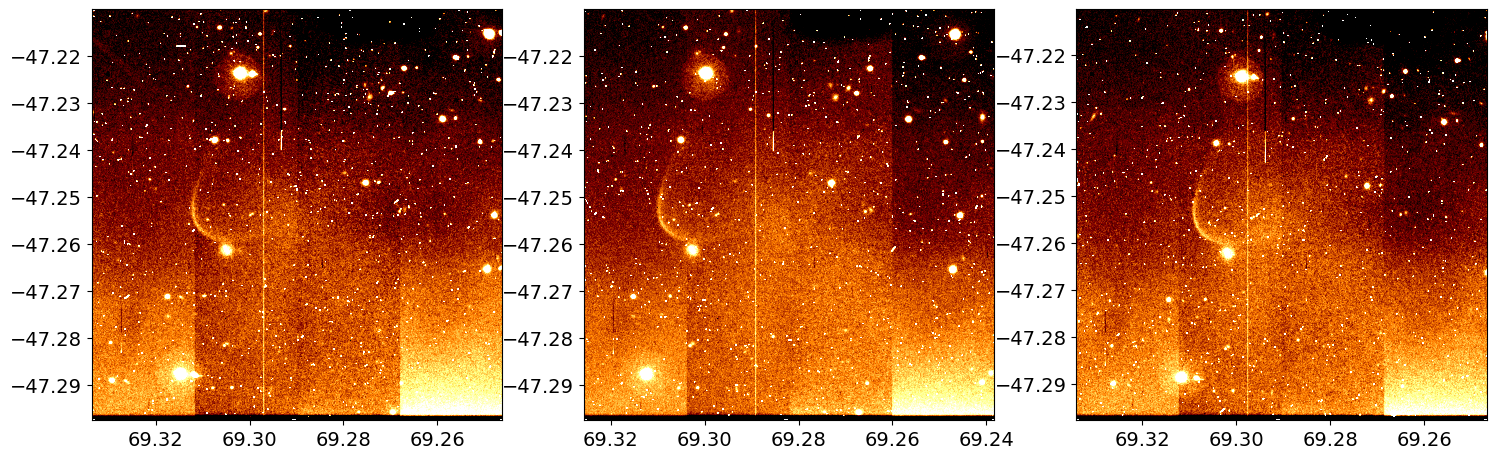

In [2]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5

files = np.sort(glob.glob(os.getcwd() + '/*fz'))

images = []
xaxes = []
yaxes = []
binning = 2

plt.figure(figsize=(18,6))
spl = 131

for fn in files:
    
    fh = fits.open(fn)

    ra = fh[0].header['TELRA']
    dec = fh[0].header['TELDEC']
    source = SkyCoord(ra, dec, frame='fk4', unit=(u.hourangle, u.deg))
    #ra = fh[0].header['RA']
    #dec = fh[0].header['DEC']
    print(ra, dec)
    
    dx = fh[0].header['PIXSCAL1']*binning
    dy = fh[0].header['PIXSCAL2']*binning

    yref = fh[1].header['CRVAL1']
    xref = fh[1].header['CRVAL2']
    xref = source.ra.deg
    yref = source.dec.deg
    
    yrefpixel = fh[1].header['CRPIX1']
    xrefpixel = fh[1].header['CRPIX2']

    for i in range(1,5):
        datatrim = fh[i].header['DATASEC']
        ytrim = slice( int(datatrim[1:3]), int(datatrim[4:7]) )
        xtrim = slice( int(datatrim[8]), int(datatrim[10:14]) )

        datai = fh[i].data
        datai = datai[xtrim, ytrim]
        datai = datai / np.median(datai)

        if i == 1:
            data = np.copy(datai)
        else:
            data = np.concatenate( (data, datai), axis=1)

    #data = gaussian_filter(data, 1)
    sig = 0.01
    vmin = np.median(data) - 2*sig*np.std(data)
    vmax = np.median(data) + 5*sig*np.std(data)

    xaxis = xref*u.deg + dx * (np.arange(data.shape[1])-xrefpixel) *u.arcsecond 
    yaxis = yref*u.deg + dy * (np.arange(data.shape[0])-yrefpixel) *u.arcsecond 
    xaxis = xaxis.value
    yaxis = yaxis.value

    plt.subplot(spl)
    spl += 1
    plt.imshow(data, vmin=vmin, vmax=vmax, cmap='afmhot', origin='lower',
              extent=[max(xaxis), min(xaxis), min(yaxis), max(yaxis)])
    images.append(data)

# Couldn't figure out absolute position offset
Shift until aligned, average with median to remove hot pixels

In [3]:
xr = slice(1024-512-64, 1024-256+64)
yr = slice(1024-256, 1024)

imslices = []
for i in range(len(images)):
    imi = images[i][yr, xr]
    imi[imi>vmax] = vmax
    imi[imi<vmin] = vmin
    imslices.append(imi)
    
ref = 2
imref = imslices[ref]
images_aligned = np.zeros((3, data.shape[0], data.shape[1]))

rolls = []
for i in range(len(imslices)):
    if i != ref:
        imagei = imslices[i]
        match = np.zeros_like(imagei)
        for j in range(imagei.shape[0]):
            for k in range(imagei.shape[1]):
                imageroll = np.roll(imagei, (j,k), axis=(0,1))
                imagemult = (imageroll*imref).sum()
                match[j,k] = imagemult
        
        #plt.figure()
        #plt.imshow(match)
        
        iy = np.argmax(match.mean(-1))
        ix = np.argmax(match.mean(0))
        
        if iy > (128):
            iy = iy-(256)
            
        image_aligned = images[i]
        image_aligned = np.roll(image_aligned, (iy, ix), axis=(0,1))
        images_aligned[i] = image_aligned
    else:
        images_aligned[i] = images[i]

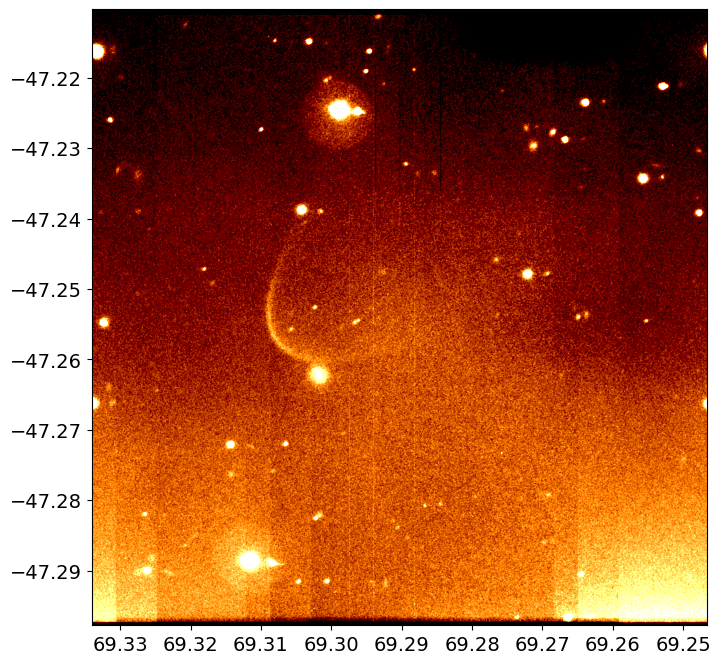

In [4]:
image_comb = np.median(images_aligned, 0)
image_comb = gaussian_filter(image_comb, 1)

plt.figure(figsize=(8,8))
plt.imshow(image_comb, vmin=vmin, vmax=vmax, cmap='afmhot', origin='lower',
          extent=[max(xaxis), min(xaxis), min(yaxis), max(yaxis)])


# Convert from ra, dec to AU, centered on the pulsar

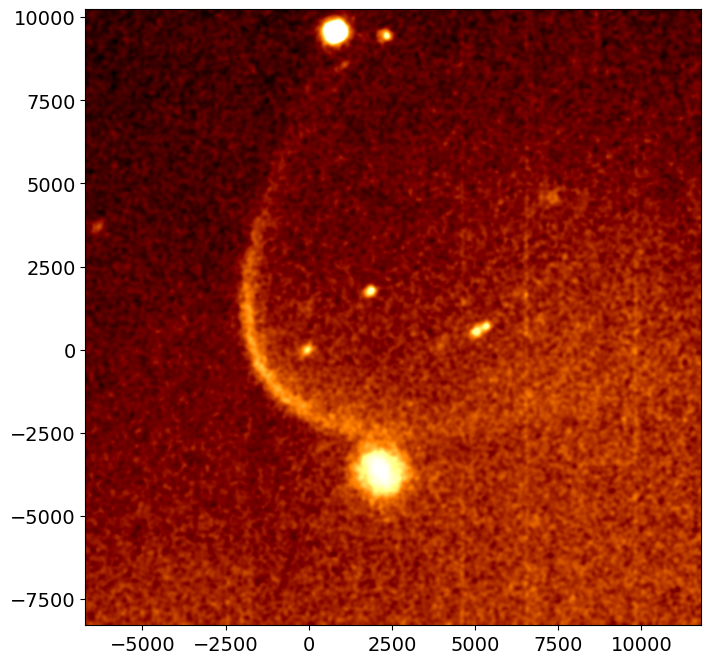

In [5]:
ylim = slice(512+128, 1024+512-128)
xlim = slice(512-128, 1024+128)

Dist = 156.79*u.pc
ra_cent = 69.27496208333334
dec_cent = -47.255726875

xAU = ((xaxis - ra_cent)*np.pi/180 *Dist).to(u.AU).value
yAU = ((yaxis - dec_cent)*np.pi/180 *Dist).to(u.AU).value

image_contour = np.copy(image_comb[ylim, xlim])
image_contour = gaussian_filter(image_contour, 2)
image_contour[image_contour > vmax] = vmax
image_contour[image_contour < vmin] = vmin
xAU = xAU[xlim]
yAU = yAU[ylim]

xx, yy = np.meshgrid(xAU, yAU)

# create vertices for a rotated mesh (3D rotation matrix)
X =  xx
Y =  yy
Z =  np.ones(X.shape)

plt.figure(figsize=(8,8))
plt.imshow(image_contour, cmap='afmhot', origin='lower',
          extent=[min(xAU), max(xAU), min(yAU), max(yAU)])

# Range of i, find distance

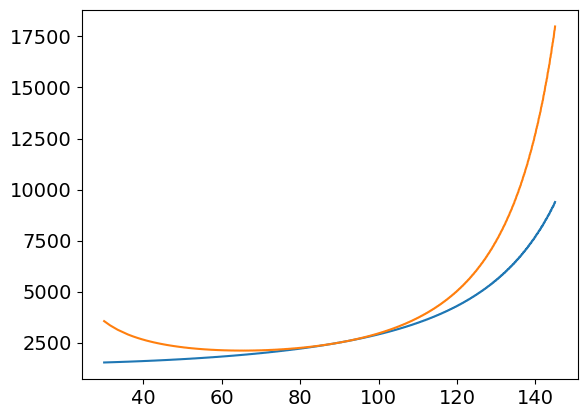

In [6]:
# Eq. 9, r(theta) of bow shock
#rproj = 1750*u.AU
rproj = 1445*u.AU  # transverse distance to H-alpha peak intensity. Assumed to be origin of scattering 

theta = np.linspace(-0.85, 0.85, 2000)*np.pi
irange = np.linspace(30, 145, 1300)*u.deg
phi = np.linspace(-1, 1, 20, endpoint=True)*np.pi

r_ts = rproj.value*np.sqrt(3*(1-theta/np.tan(theta))) / abs(np.sin(theta))

dpls = []
for i in irange:

    # Angle between line of sight and pulsar motion.
    # i=0 corresponds to pulsar moving directly towards up
    irad = i.to(u.rad).value
    inorm = irad + np.pi/2.

    index = np.argmin( abs(theta-irad) )
    dpl = r_ts[index]
    dpls.append(dpl)


# Analytic shock shape, pointing towards Earth
r_ts, phi = np.meshgrid(r_ts, phi)
rts_phys = r_ts*rproj

# Hyperbola, heuristic model
ecc = 1.08
r_fi = 1280
rproj = 1280 *u.AU
i = 114*np.pi/180
scale = 2
pmi = (-38.9 + 5)*np.pi/180
r_ts = r_fi * scale*ecc / (1+ecc*np.cos(theta))

z_s = r_ts * np.cos(theta)
x_s = r_ts * np.sin(theta) * np.cos(phi)
y_s = r_ts * np.sin(theta) * np.sin(phi)

xmaxs = []
for i in irange:

    # rotate along y axis, inclination of shock
    x_s_i = x_s * np.cos(i) + z_s * np.sin(i)
    y_s_i = y_s
    z_s_i = -x_s * np.sin(i) + z_s * np.cos(i)

    xproj = np.max(x_s_i)
    xmaxs.append(xproj)

    
xmaxs = np.array(xmaxs)
dpls_corr = dpls * (xmaxs / np.min(xmaxs))
r_forward = rproj.value / (xmaxs / np.min(xmaxs))

plt.plot(irange.value, dpls, label='Bow shock geometric model')
plt.plot(irange.value, dpls_corr, label='Bow shock geometric model')

104.73362789262771 km / s 90.26018083386873 km / s -53.1246888686298 km / s
inclination = 117.98962677273738 deg
vra, vdec, vz = 90.26018083386873 km / s, -53.1246888686298 km / s, -55.69698320864127


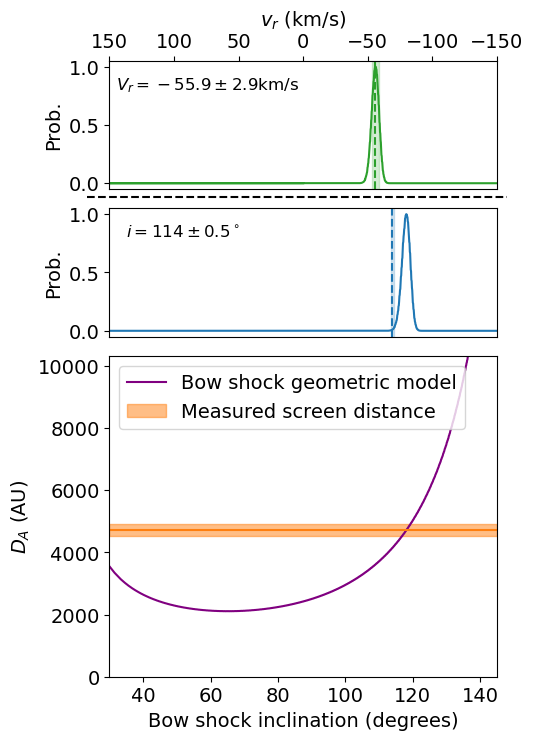

In [7]:
Dist = 156.79*u.pc
PMRA  = 121.4385*u.milliarcsecond / u.year
PMDEC = -71.4754*u.milliarcsecond / u.year
vpra = (PMRA * Dist / u.rad).to(u.km/u.s)
vpdec = (PMDEC * Dist / u.rad).to(u.km/u.s)
Vpm = np.sqrt(PMRA**2 + PMDEC**2)*Dist / u.rad
Vpm = Vpm.to(u.km/u.s)
print(Vpm, vpra, vpdec)

dpl_meas = 4720
dpl_err = 190

dpl_range = np.linspace(0, 8000, 2001)
dpl_grid = np.zeros((len(irange), len(dpl_range)))

dpl_constraint = np.exp( -(dpl_range - dpl_meas)**2 / (2*dpl_err**2) )
dpl_grid[:] = dpl_constraint

idpl_grid = np.zeros_like(dpl_grid)

Vzs = []

for k in range(len(irange)):
    i = irange[k]
    dplk = dpls_corr[k]
    index_dpl = np.argmin( np.abs(dpl_range- dplk) )
    idpl_grid[k, index_dpl] = 1
    Vzi = Vpm / np.tan(i)
    Vzs.append(Vzi.value)
Vzs[0] = 0
combined_post = idpl_grid * dpl_grid
combined_post1D = combined_post.sum(-1)
Vz_dist = np.sum( combined_post1D*Vzs ) / np.sum(combined_post1D)
i_meas = np.sum( combined_post1D*irange ) / np.sum(combined_post1D)
print("inclination = {0}".format(i_meas))
print("vra, vdec, vz = {0}, {1}, {2}".format(vpra, vpdec, Vz_dist) )

def gaussian(x, x0, sigma, A):
    return A * np.exp( -(x-x0)**2  / (2*sigma**2) )

p0 = [-60, 5, 1]
popt, pcov = curve_fit(gaussian, Vzs[1:], combined_post1D[1:], p0=p0)
Vz = np.round(popt[0], 1)
Vzerr = np.round(popt[1], 1)

p0 = [114., 5, 1]
popt, pcov = curve_fit(gaussian, irange[1:], combined_post1D[1:], p0=p0)
ifit = np.round(popt[0], 1)
ifiterr = np.round(popt[1], 1)

ifit = 114
ifiterr = 0.5

fig, (axv, ax0, ax1) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 2.5]}, figsize=(5, 8))

plt.subplots_adjust(hspace = 0.1)

#ax1.plot(irange, dpls, label='Bow shock geometric model')
#ax1.plot(irange.value, dpls_corr, label='Bow shock proj. corr', color='purple')
ax1.plot(irange.value, dpls_corr, label='Bow shock geometric model', color='purple')


ax1.axhline(dpl_meas, color='tab:orange')
ax1.axhspan(dpl_meas-dpl_err, dpl_meas+dpl_err, alpha=0.5, color='tab:orange', label='Measured screen distance')

ax1.set_ylim(0, max(dpls)*1.1)
ax1.set_xlim(min(irange.value), max(irange.value) )
ax1.set_ylabel(r'$D_{A}$ (AU)', fontsize=14)
ax1.set_xlabel(r'Bow shock inclination (degrees)', fontsize=14)
ax1.legend()

ax0.plot(irange, combined_post1D)
ax0.set_xlim(min(irange.value), max(irange.value) )
ax0.set_ylabel('Prob.', fontsize=14)
ax0.set_xticks([])
ax0.axvline(ifit, linestyle='--', color='tab:blue')
ax0.axvspan(ifit-ifiterr, ifit+ifiterr, alpha=0.2, color='tab:blue')
ax0.text(35, 0.8, r"$i = {0}\pm{1}^\circ$".format(np.round(ifit, 1), np.round(ifiterr,1)), fontsize=12)

axv.plot(Vzs, combined_post1D, color='tab:green')
#plt.plot(Vzs, gaussian(Vzs, *popt))
axv.axvline(Vz, linestyle='--', color='tab:green')
axv.axvspan(Vz-Vzerr, Vz+Vzerr, alpha=0.2, color='tab:green')
axv.set_ylabel('Prob.', fontsize=14)
axv.text(145, 0.8, r"$V_r = {0}\pm{1} \rm km/s$".format(np.round(Vz, 1), np.round(Vzerr,1)), fontsize=12)

axv.xaxis.tick_top()
axv.xaxis.set_label_position('top') 

#plt.yscale('symlog')
axv.set_xlim(150, -150)
axv.set_xlabel(r"$v_{r}$ (km/s)", fontsize=14)

# Draw a horizontal lines at those coordinates
line = plt.Line2D([0.08,0.92],[0.71,0.71], transform=fig.transFigure, color="black", linestyle='--')
fig.add_artist(line)

plt.savefig('BowShockConstraints.pdf', bbox_inches='tight')

# Overlay 3D shock model on H-alpha image

## First attempt, using 3D plot projected onto 2D axis

1159.8439848600146


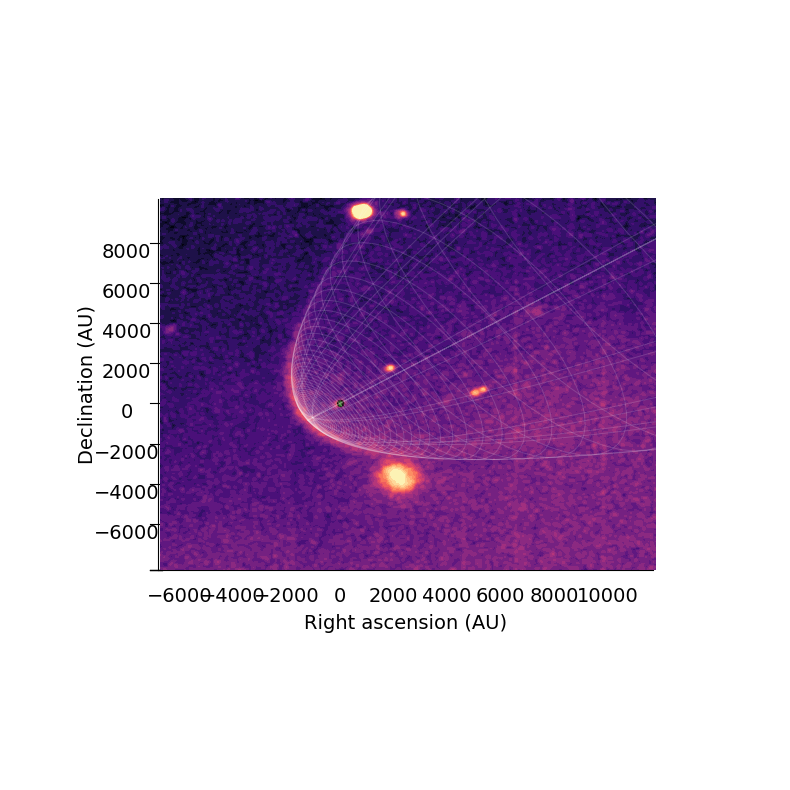

In [8]:
import matplotlib.tri as mtri

i = 122.6*u.deg
# angle of proper motion, and angle to closest projected separation
pm_psr = -30.5*u.deg
pmi = -38.9*u.deg
cmap = 'magma'

# Best fit inclination
i = ifit*u.deg
index = np.argmin( np.abs(irange-i) )
r_fi = r_forward[index]
# r_fi = 1445

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10,10))

theta = np.linspace(-0.85, 0.85, 100, endpoint=True)*np.pi

phi = np.linspace(-1, 1, 50, endpoint=True)*np.pi
pmra = 90.
pmdec = -53.
pmz = -44.
#pmz = -76.

# Convert to deg, reference to actual pulsar position
print(r_fi)
r_ts = r_fi*np.sqrt(3*(1-theta/np.tan(theta))) / abs(np.sin(theta))

# Hyperbola, heuristic model
ecc = 1.06
r_fi = 1307
i = 113*np.pi/180
scale = 2
pmi = (-38.9 + 4.11)*np.pi/180
r_ts = r_fi * scale*ecc / (1+ecc*np.cos(theta))

r_ts, phi = np.meshgrid(r_ts, phi)

# Analytic shock shape, pointing towards Earth
z_s = r_ts * np.cos(theta)
x_s = r_ts * np.sin(theta) * np.cos(phi)
y_s = r_ts * np.sin(theta) * np.sin(phi)

# rotate along y axis, inclination of shock
x_s_i = x_s * np.cos(i) + z_s * np.sin(i)
y_s_i = y_s
z_s_i = -x_s * np.sin(i) + z_s * np.cos(i)

# rotate along z axis, proper motion
x_s_r = x_s_i * np.cos(pmi) - y_s_i * np.sin(pmi)
y_s_r = x_s_i * np.sin(pmi) + y_s_i * np.cos(pmi)
z_s_r = z_s_i

x_s_r = -x_s_r #+ xth_ref
y_s_r = y_s_r #+ yth_ref

##########################################

# Plot line
ax.scatter(0,0,0,color='k',zorder=-1,marker='o',s=20,edgecolors='k',alpha=.8)
# distance to shock
ax.quiver(0, 0, 0, 0, 1, 0, length=4800,arrow_length_ratio=.1,lw=2.0,alpha=0.7,
          color='tab:green',label=r'd$_{\rm ps}$')
# proper motion
#ax.quiver(0, 0, 0, pmra, pmdec, pmz, length=10,arrow_length_ratio=.3,lw=2.0,alpha=0.7,
#          color='tab:orange',label=r'$\mathbf{v}_{\mathrm{psr}}$')


# Plot x, z, y array
ax.plot_wireframe(x_s_r, z_s_r, y_s_r,  rstride=0, cstride=2,alpha=0.15,lw=0.7, color='w')
ax.plot_wireframe(x_s_r, z_s_r, y_s_r,  rstride=5, cstride=0,alpha=0.15,lw=0.7, color='w')

# axis lims
ax.set_proj_type('ortho')

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# View angle
ax.view_init(0, -90)
ax.set_ylabel('')
ax.set_yticklabels([])
#ax.set_xticklabels(ticks_convert(ax.get_xticks()))

vmin = np.median(image_contour) - 2*np.std(image_contour)
vmax = np.median(image_contour) + 5*np.std(image_contour)
ax.contourf(X, image_contour, Y, 20, zdir='y', offset=0.5, cmap=cmap)
                  #vmin=vmin, vmax=vmax)
    
ax.tick_params(axis='x', pad=5)
ax.tick_params(axis='z', pad=10)
ax.set_zticks(np.linspace(-6000, 10000, 9, endpoint=True))

ax.set_zlabel(r'Declination (AU)', fontsize=14, labelpad=20)
ax.set_xlabel(r'Right ascension (AU)', fontsize=14, labelpad=20)

ax.set_xlim(np.min(X)*0.96, np.max(X)*0.96)
ax.set_zlim(np.min(Y)*0.96, np.max(Y)*0.96)

#plt.legend(fontsize=12, loc=3)

plt.savefig("BowShockOverplot_3D.pdf", bbox_inches='tight')

## Second attempt, just plotting as a 2D image

-0.5075383629607041 0.8616291604415258


/var/folders/0d/3n4fgnc56j18ryg6n7s9jw341mfmjs/T/ipykernel_52755/3280300107.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


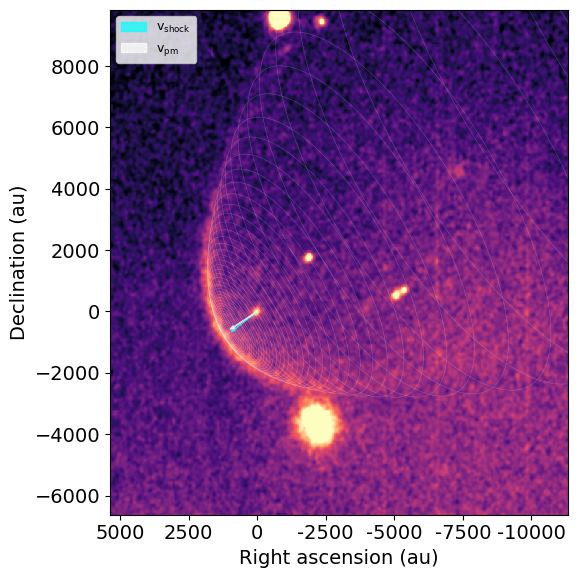

In [10]:
## Add proper motion, and v_ps (slightly off)
## Quote minimum vIISM to match

#matplotlib.rc('text', usetex=False)
#matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

cmap = 'magma'
fig, ax = plt.subplots(figsize=(6,6))

plt.pcolormesh(xAU, yAU, image_contour, cmap=cmap, vmin=vmin, vmax=vmax,linewidth=0,rasterized=True)
plt.plot(x_s_r, y_s_r, color='w', alpha=0.15, linewidth=0.3)


arrowscale = 1000
x1 = -arrowscale*np.cos(pmi)
y1 = arrowscale*np.sin(pmi)
plt.arrow(0, 0, x1, y1, lw=1.0,alpha=0.7, head_width=100,
          color='cyan',label=r'v$_{\rm shock}$')

x1 = float(-arrowscale*np.cos(pm_psr))
y1 = float(arrowscale*np.sin(pm_psr))
print(np.sin(pm_psr), np.cos(pm_psr))
plt.arrow(0, 0, x1, y1, lw=1.0,alpha=0.7, head_width=100,
          color='w',label=r'v$_{\rm pm}$')

plt.xlim(np.min(xAU)*0.8, np.max(xAU)*0.96)
plt.ylim(np.min(yAU)*0.8, np.max(yAU)*0.96)

plt.ylabel(r'Declination (au)', fontsize=14)
plt.xlabel(r'Right ascension (au)', fontsize=14)

labels = [str(-int(item.get_text().replace('−','-'))) for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

plt.legend(fontsize=9)
#plt.savefig("BowShockOverplot-2D.png", bbox_inches='tight')
plt.tight_layout()
plt.savefig("BowShockOverplot-2D.pdf", bbox_inches='tight')
#plt.savefig("BowShockOverplot-Heuristic.pdf", bbox_inches='tight')

## Find psr position from centroid
proj distance from pulsar along shock
min distance, angle as inputs to model

Two model ideas:
1) Use projected distance to shock front, d_ls from scintillation.  Assume alignment with proper motion
2) Measure r_proj(theta).  Use scintillation d_ls as prior, fit for v_ism,x v_ism,y, v_z (v_p,z + v_ism,z)


69.27496208333334 -47.255726875


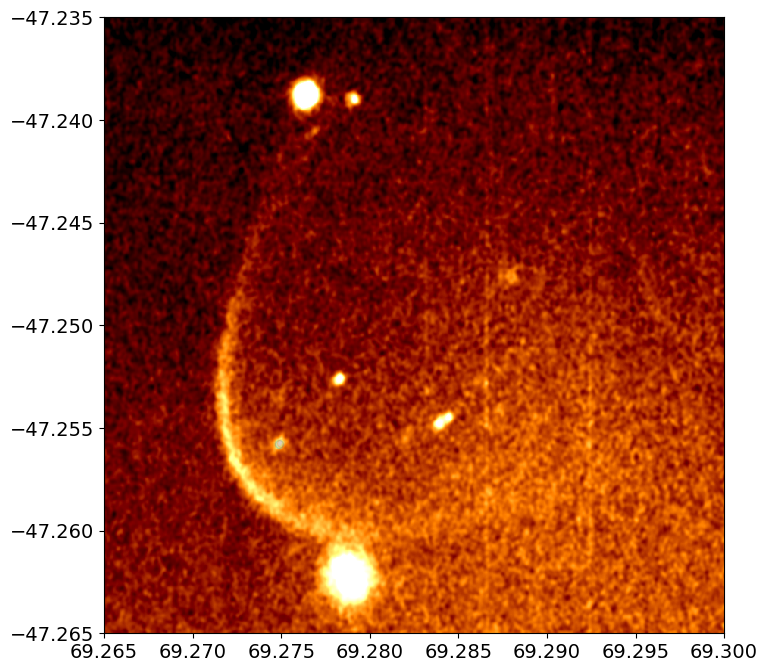

In [10]:
image_smooth = gaussian_filter(image_comb, 2)

plt.figure(figsize=(8,8))
plt.pcolormesh(xaxis, yaxis, image_smooth, vmin=vmin, vmax=vmax, cmap='afmhot')

plt.xlim(69.265, 69.3)
plt.ylim(-47.265, -47.235)

# starting guess (also overplot it)
ra0 = 69.2749
dec0 = -47.2558
plt.scatter(ra0, dec0, alpha=0.2)

# find centroid
w = 0.001
raslice = np.argwhere( np.abs(xaxis-ra0) < w ).squeeze()
decslice = np.argwhere( np.abs(yaxis-dec0) < w ).squeeze()
imc = image_smooth[decslice]
imc = imc[:,raslice]
imc = imc - np.min(imc)
rac = xaxis[raslice]
decc = yaxis[decslice]


#plt.figure()
#plt.plot(rac, imc.mean(0))

#plt.figure()
#plt.plot(decc, imc.mean(1))
dec_cent = decc[np.argmax(imc.mean(1))]
ra_cent = rac[np.argmax(imc.mean(0))]

plt.scatter(ra_cent, dec_cent, alpha=0.2)

print(ra_cent, dec_cent)




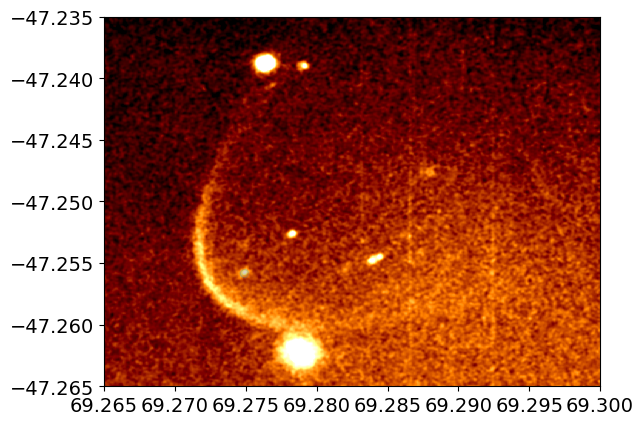

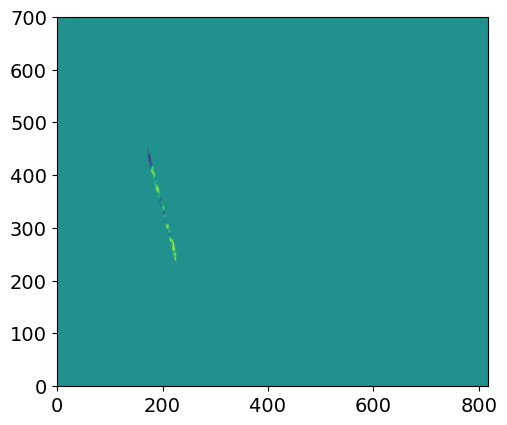

In [11]:
plt.pcolormesh(xaxis, yaxis, image_smooth, vmin=vmin, vmax=vmax, cmap='afmhot')

plt.xlim(69.265, 69.3)
plt.ylim(-47.265, -47.235)

plt.scatter(ra0, dec0, alpha=0.2)

# find centroid
w = 0.001
raslice = np.argwhere( np.abs(xaxis-ra0) < w ).squeeze()
decslice = np.argwhere( np.abs(yaxis-dec0) < w ).squeeze()
imc = image_smooth[decslice]
imc = imc[:,raslice]
imc = imc - np.min(imc)
rac = xaxis[raslice]
decc = yaxis[decslice]


#plt.figure()
#plt.plot(rac, imc.mean(0))

#plt.figure()
#plt.plot(decc, imc.mean(1))
dec_cent = decc[np.argmax(imc.mean(1))]
ra_cent = rac[np.argmax(imc.mean(0))]

plt.scatter(ra_cent, dec_cent, alpha=0.2)

width = 0.0005
cutdist = 0.01
thetacut = np.linspace(15, 255, 100)*u.deg

imcut = image_smooth[:,(xaxis>69.265) & (xaxis<69.3)]
imcut = imcut[(yaxis>-47.265) & (yaxis<-47.235)]
ycut = yaxis[(yaxis>-47.265) & (yaxis<-47.235)]
xcut = xaxis[(xaxis>69.265) & (xaxis<69.3)]
xcut = xcut - ra_cent
ycut = ycut - dec_cent


imcut = imcut - np.median(imcut)
imcutbg = imcut - median_filter(imcut, 100)

rs = []

for thi in thetacut:
    imi = np.zeros_like(imcutbg)
    line = np.linspace(0.001,cutdist)
    yline = -line * np.sin(thi)
    xline = line * np.cos(thi)

    slope = (yline[-1] - yline[0]) / (xline[-1] - xline[0])
    
    for i,xi in enumerate(xcut):
        if (xi > np.min(xline)) & (xi < np.max(xline)):
            yi = slope * xi # (xi-ra_cent) + dec_cent
            yrange = np.argwhere( np.abs(ycut-yi) < width ).squeeze()
            imi[yrange,i] = imcut[yrange, i]            
            
    if np.abs(thi.value%180 - 90) < 22.5:
        r = np.sqrt( ycut**2  + ((1/slope)*ycut)**2 ) * np.sign(ycut)
        prof = imi.mean(1)
    else:
        prof = imi.mean(0)
        r = np.sqrt( xcut**2  + (slope*xcut)**2 ) * np.sign(xcut)
    peak = np.argmax(prof)
    rs.append(r[peak])
            

plt.figure()
plt.imshow(imi, origin='lower')

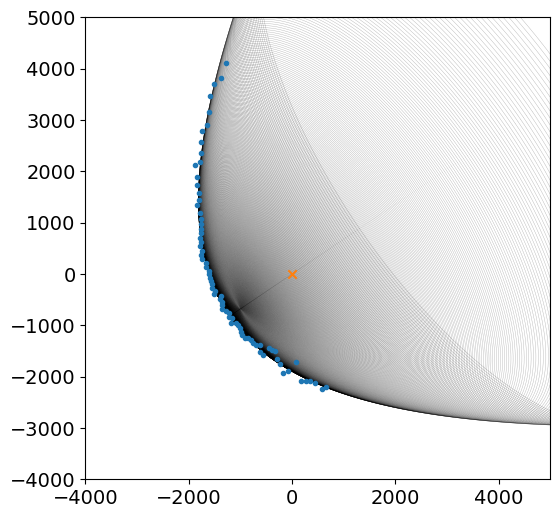

(1000, 1000)


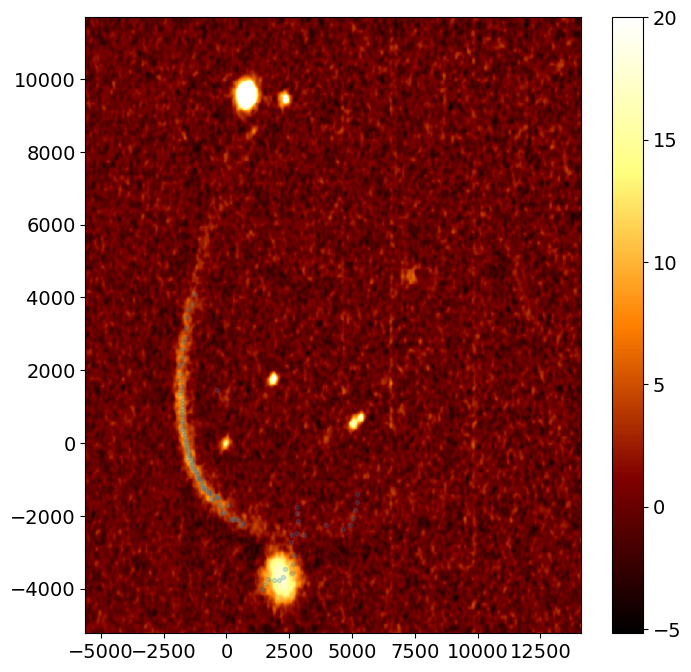

In [12]:
imcutbg = imcutbg / np.std(imcutbg[:50,:50])
rs = np.array(rs)
ys = (-np.abs(rs) * np.sin(thetacut) * np.pi/180 *Dist).to(u.AU).value
xs = (np.abs(rs) * np.cos(thetacut) * np.pi/180 *Dist).to(u.AU).value

xAU2 = ((xcut*np.pi/180)*Dist).to(u.AU).value
yAU2 = ((ycut*np.pi/180)*Dist).to(u.AU).value

# fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(6, 6))
plt.figure(figsize=(6,6))
indx = np.argwhere( (xs < 1350) * (ys > -4000) * ~( (ys > 0) * (xs > -500) ) ) # filter spurious points
plt.scatter(xs[indx], ys[indx], marker='.', color='C0', zorder=10)
plt.scatter([0], [0], marker='x', color='C1', zorder=10)

# fit a model
#1280, 114, 4.7, 1.08, 1

#parameters
r_0 = 1280
i = 114
dpmi = 4.7
ecc = 1.08

pmi = -38.9 * np.pi/180  # pmi.value
i *= np.pi/180
dpmi *= np.pi/180


theta = np.linspace(-0.7, 0.7, 1000, endpoint=True)*np.pi
phi = np.linspace(-1, 1, 1000, endpoint=True)*np.pi
pmra = 90.
pmdec = -53.
pmz = -44.

r_ts = r_0*np.sqrt(3*(1-theta/np.tan(theta))) / abs(np.sin(theta))

# Conic section heuristic model
directrix = r_0 * 2  # for a parabola
r_ts = directrix * ecc / ( 1 + ecc * np.cos(theta) )

r_ts, phi = np.meshgrid(r_ts, phi)

# Analytic shock shape, pointing towards Earth
z_s = r_ts * np.cos(theta)
x_s = r_ts * np.sin(theta) * np.cos(phi)
y_s = r_ts * np.sin(theta) * np.sin(phi)

# rotate along y axis, inclination of shock
x_s_i = x_s * np.cos(i) + z_s * np.sin(i)
y_s_i = y_s
z_s_i = -x_s * np.sin(i) + z_s * np.cos(i)

# rotate along z axis, proper motion
x_s_r = x_s_i * np.cos(pmi + dpmi) - y_s_i * np.sin(pmi + dpmi)
y_s_r = x_s_i * np.sin(pmi + dpmi) + y_s_i * np.cos(pmi + dpmi)
z_s_r = z_s_i

x_s_r = -x_s_r #+ xth_ref
y_s_r = y_s_r #+ yth_ref

# Plot x, z, y array
plt.plot(x_s_r, y_s_r, color='k', alpha=0.15, linewidth=0.3, zorder=3)

#rproj = np.sqrt(x_s_r**2 + y_s_r**2)
#inds = np.argwhere(rproj >= 1400)
#plt.plot(x_s_r[inds], y_s_r[inds])
#print(rproj)

plt.xlim(-4000, 5000)
plt.ylim(-4000, 5000)

plt.show()

z = np.abs(z_s_r)
print(np.shape(z))


plt.figure(figsize=(8,8))
plt.pcolormesh(xAU2, yAU2, imcutbg, cmap='afmhot', vmax=20)
plt.colorbar()
plt.scatter(xs, ys, marker='.', alpha=0.2)

#plt.xlim(-5000, 8000)
#plt.ylim(-5000, 8000)

plt.show()



TypeError: Dimensions of C (701, 818) should be one smaller than X(768) and Y(768) while using shading='flat' see help(pcolormesh)

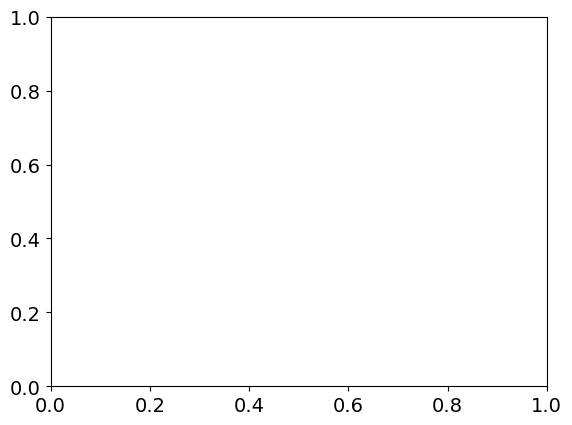

In [13]:
imcutsmooth = gaussian_filter(imcutbg, 2)

imcutsmooth = imcutsmooth / np.std(imcutsmooth[:50,:50])
mask = np.zeros_like(imcutsmooth)
mask[imcutsmooth > 3] = 1

plt.pcolormesh(xAU, yAU, mask, cmap='Greys')


In [ ]:
#pmi = -30.5*u.deg
#i = 121.4*u.deg
i = 122.6*u.deg

#pmi = -50.5*u.deg
pmi = -50*u.deg

index = np.argmin(np.abs(irange-i))
rw = xmaxs[index]
print(rw)

theta = np.linspace(-0.75, 0.75, 50, endpoint=True)*np.pi
phi = np.linspace(-1, 1, 50, endpoint=True)*np.pi
rw = 1400.
pmra = 90.
pmdec = -53.
pmz = -67.
#pmz = -76.

xth = rw*u.AU / Dist
xth = (xth.decompose()*u.rad).to(u.deg).value
yth_ref = -47.2557
xth_ref = 69.27496

r_ts = rw*np.sqrt(3*(1-theta/np.tan(theta))) / abs(np.sin(theta))
r_ts, phi = np.meshgrid(r_ts, phi)

# Analytic shock shape, pointing towards Earth
z_s = r_ts * np.cos(theta)
x_s = r_ts * np.sin(theta) * np.cos(phi)
y_s = r_ts * np.sin(theta) * np.sin(phi)

# rotate along y axis, inclination of shock
x_s_i = x_s * np.cos(i) + z_s * np.sin(i)
y_s_i = y_s
z_s_i = -x_s * np.sin(i) + z_s * np.cos(i)

# rotate along z axis, proper motion
x_s_r = x_s_i * np.cos(pmi) - y_s_i * np.sin(pmi)
y_s_r = x_s_i * np.sin(pmi) + y_s_i * np.cos(pmi)
z_s_r = z_s_i

x_s_r = -x_s_r

rproj = np.sqrt(x_s_r**2 + y_s_r**2)

plt.pcolormesh(xAU2, yAU2, mask, cmap='Greys')

plt.scatter(x_s_r, z_s_r, marker='.', alpha=0.1, color='r')
#plt.scatter(xs, ys, marker='.', alpha=0.2, color='blue')


In [ ]:
#pmi = -30.5*u.deg
#i = 121.4*u.deg
i = 122.6*u.deg

#pmi = -50.5*u.deg
pmi = -50*u.deg

index = np.argmin(np.abs(irange-i))
rw = xmaxs[index]
print(rw)

theta = np.linspace(-0.75, 0.75, 50, endpoint=True)*np.pi
phi = np.linspace(-1, 1, 50, endpoint=True)*np.pi
rw = 1400.
pmra = 90.
pmdec = -53.
pmz = -67.
#pmz = -76.

xth = rw*u.AU / Dist
xth = (xth.decompose()*u.rad).to(u.deg).value
yth_ref = -47.2557
xth_ref = 69.27496

r_ts = rw*np.sqrt(3*(1-theta/np.tan(theta))) / abs(np.sin(theta))
r_ts, phi = np.meshgrid(r_ts, phi)

# Analytic shock shape, pointing towards Earth
z_s = r_ts * np.cos(theta)
x_s = r_ts * np.sin(theta) * np.cos(phi)
y_s = r_ts * np.sin(theta) * np.sin(phi)

# rotate along y axis, inclination of shock
x_s_i = x_s * np.cos(i) + z_s * np.sin(i)
y_s_i = y_s
z_s_i = -x_s * np.sin(i) + z_s * np.cos(i)

# rotate along z axis, proper motion
x_s_r = x_s_i * np.cos(pmi) - y_s_i * np.sin(pmi)
y_s_r = x_s_i * np.sin(pmi) + y_s_i * np.cos(pmi)
z_s_r = z_s_i

x_s_r = -x_s_r

rproj = np.sqrt(x_s_r**2 + y_s_r**2)

plt.pcolormesh(xAU2, yAU2, mask, cmap='Greys')

plt.scatter(x_s_r, z_s_r, marker='.', alpha=0.1, color='r')
#plt.scatter(xs, ys, marker='.', alpha=0.2, color='blue')


In [ ]:
# rather than leave fixed, use vism_ra, vism_dec.
# Easiest observable, rproj_min (and perhaps theta_rproj)
# Only unknown is v_z

In [ ]:
zl = z_s_r[abs(x_s_r<10) & (abs(y_s_r<10))]
print(np.max(zl))

In [ ]:
r_theta = (np.abs(rs)* np.pi/180 *Dist).to(u.AU).value
r_theta = gaussian_filter(r_theta, 2)
print(r_theta[np.argmin(r_theta)], thetacut[np.argmin(r_theta)] )

plt.plot(thetacut, r_theta)
plt.ylim(1400, 1700)

def parabola(x, x0, curv, A):
    return curv*(x-x0)**2 + A 

p0 = [140, 5, 1470]
popt, pcov = curve_fit(parabola, thetacut.value[r_theta< 1600], r_theta[r_theta< 1600], p0=p0)
    
thetamid = popt[0]
thetamiderr = np.sqrt(pcov[0][0])

print(thetamid, thetamiderr)
plt.plot(thetacut, parabola(thetacut.value, *popt))

In [ ]:
index = np.argmin( np.abs(thetacut.value - thetamid) )

thi = thetacut[index]
imi = np.zeros_like(imcutbg)
line = np.linspace(0.001,cutdist)
yline = -line * np.sin(thi)
xline = line * np.cos(thi)

slope = (yline[-1] - yline[0]) / (xline[-1] - xline[0])

for i,xi in enumerate(xcut):
    if (xi > np.min(xline)) & (xi < np.max(xline)):
        yi = slope * xi # (xi-ra_cent) + dec_cent
        yrange = np.argwhere( np.abs(ycut-yi) < width ).squeeze()
        imi[yrange,i] = imcut[yrange, i]            

if np.abs(thi.value%180 - 90) < 22.5:
    r = np.sqrt( ycut**2  + ((1/slope)*ycut)**2 ) * np.sign(ycut)
    prof = imi.mean(1)
else:
    prof = imi.mean(0)
    r = np.sqrt( xcut**2  + (slope*xcut)**2 ) * np.sign(xcut)
    
prof = prof / np.max(prof)
r = (r * np.pi/180 *Dist).to(u.AU).value
plt.plot(r, prof)


import scipy.optimize as so
def gaussian(x, x0, sig, A):
    return A * np.exp(-(x-x0)**2 / (2*sig)**2 )  
    
p0 = [-1500., 300, 1]
popt, pcov = so.curve_fit(gaussian, r[r< -1300], prof[r<-1300], p0=p0)
    
shockmid = popt[0]
shockwidth = popt[1]

shockmiderr = np.sqrt(pcov[0][0])
shockwidtherr = np.sqrt(pcov[1][1])
print(shockmiderr, shockwidtherr)

# HW at 0.1
# HWHM has ln(2)
W = shockmid - np.sqrt(2*np.log(10))*shockwidth
Werr = np.sqrt( shockmiderr**2 + np.sqrt(2*np.log(10))*shockwidtherr**2)

print(f"ShockPeak: {shockmid} +- {shockwidtherr}")
print(f"HW at 10%: {W} +- {Werr}")

plt.plot(r, gaussian(r, *popt))
plt.xlim(-3000, 0)



# Diagram

In [ ]:
plt.figure(figsize=(5, 5))
ax = plt.subplot(111)

rproj = 1750 * u.AU

thetaplot = np.linspace(-0.75, 0.75, 2000)*np.pi

xprofs = []
yprofs = []

for fi in [1, 0.9, 0.8]:

    r_ts = fi*rproj.value*np.sqrt(3*(1-thetaplot/np.tan(thetaplot))) / abs(np.sin(thetaplot))

    x = r_ts * np.sin(thetaplot)
    y = r_ts * np.cos(thetaplot) - (1-fi)*rproj.value

    xprofs.append(x)
    yprofs.append(y)

for i in range(len(xprofs)):
    x = xprofs[i]
    y = yprofs[i]
    plt.plot(x, y, color='k', linewidth=1)


#plt.fill_between(x, yprofs[1], yprofs[2], color='grey', alpha=0.2)
#plt.fill(xprofs[1], yprofs[1], 'grey', xprofs[2], yprofs[2], 'w') 
#plt.fill(xprofs[0], yprofs[0], 'tab:orange', xprofs[1], yprofs[1], 'w') 
plt.fill(xprofs[0], yprofs[0], 'tab:red', alpha=0.2) 
plt.fill(xprofs[1], yprofs[1], 'w') 

plt.scatter(0,0, marker='*', s=100)
plt.text(-500, -300, "pulsar")

plt.text(900, -1700, "line of sight", rotation=90-128)
plt.text(-1150, 1850, "forward shock")
plt.text(-4800, 1300, "    contact \n discontinuity")
plt.text(-4800, 500, " termination \n     shock")
plt.text(2400, 1500, "shocked ISM", color='tab:red')

plt.text(100, 250, r'$v_{\rm shock}$', color='tab:blue', rotation=90, fontsize=12)


scale = 10000
xobs = scale*np.sin(i)
yobs = scale*np.cos(i)
plt.plot( [0, xobs], [0, yobs], linestyle='dotted', color='k')
plt.plot([0, -2600], [1400, 1500], color='k', linestyle='dotted')
plt.plot([0, -2600], [1050, 800], color='k', linestyle='dotted')
plt.plot([0, 2200], [1550, 1550], color='tab:red', linestyle='dotted')
plt.arrow(0, 0, 0, 900, lw=1.0,alpha=0.7, head_width=100,
          color='tab:blue',label=r'v$_{\rm ps}$')

plt.ylim(-3000, 3000)
plt.xlim(-5000, 5000)
plt.ylabel('r (AU)', fontsize=14)
plt.xlabel('x (AU)', fontsize=14)

plt.savefig('ShockDiagram.pdf', bbox_inches='tight')

In [ ]:
dx

In [ ]:
import bilby
import enterprise
import enterprise_extensions
from scintools.dynspec import Dynspec
import emcee
import lmfit
import libstempo as t2
import pint
import psrchive
from coast_guard.cleaners import surgical
import astropy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

pmi = -38.9  # pmi.value

# parameters
r_0 = 1300
i = 120 * np.pi / 180
dpmi = 15 * np.pi / 180
ecc = 1.0

theta = np.linspace(-0.7, 0.7, 100, endpoint=True) * np.pi
phi = np.linspace(-1, 1, 100, endpoint=True) * np.pi

r_ts = r_0*np.sqrt(3*(1-theta/np.tan(theta))) / abs(np.sin(theta))

directrix = r_0 * 2 
r_ts = directrix * ecc / ( 1 + ecc * np.cos(theta) )

r_ts_m, phi_m = np.meshgrid(r_ts, phi)

# Analytic shock shape, pointing towards Earth
z_s = r_ts_m * np.cos(theta)
x_s = r_ts_m * np.sin(theta) * np.cos(phi_m)
y_s = r_ts_m * np.sin(theta) * np.sin(phi_m)

x_s_i = x_s * np.cos(i) + z_s * np.sin(i)
y_s_i = y_s
z_s_i = -x_s * np.sin(i) + z_s * np.cos(i)

x_s_r = x_s_i * np.cos(pmi + dpmi) - y_s_i * np.sin(pmi + dpmi)
y_s_r = x_s_i * np.sin(pmi + dpmi) + y_s_i * np.cos(pmi + dpmi)
z_s_r = z_s_i

x_s_r = -x_s_r
y_s_r = y_s_r

# Plot x and y corrdinates of the 2D projection only
plt.scatter(x_s_r, y_s_r, marker='.', color='k', s=1)

from scipy.spatial import ConvexHull

# Flatten the 2D arrays to 1D arrays
x_s_r_flatten = x_s_r.flatten()
y_s_r_flatten = y_s_r.flatten()

# Combine the x and y coordinates to create an array of 2D points
points_2d = np.vstack((x_s_r_flatten, y_s_r_flatten)).T

# Find the convex hull of the 2D points
hull = ConvexHull(points_2d)

# Extract the vertices of the convex hull
vertices = points_2d[hull.vertices]
x_vertices = vertices[:,0]
y_vertices = vertices[:,1]

# Plot the original scatter plot and the convex hull
plt.plot(x_vertices, y_vertices, 'r-', lw=2)

In [ ]:
z_flatten_positive_z

In [ ]:
np.array(xi)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull, distance
from scipy.interpolate import griddata

pmi = -38.9  # pmi.value

# parameters
r_0 = 1307
i = 113 * np.pi / 180
dpmi = 4.11 * np.pi / 180
ecc = 1.06

theta = np.linspace(-0.7, 0.7, 100, endpoint=True) * np.pi
phi = np.linspace(-1, 1, 100, endpoint=True) * np.pi

directrix = r_0 * 2 
r_ts = directrix * ecc / ( 1 + ecc * np.cos(theta) )

r_ts_m, phi_m = np.meshgrid(r_ts, phi)

# Analytic shock shape, pointing towards Earth
z_s = r_ts_m * np.cos(theta)
x_s = r_ts_m * np.sin(theta) * np.cos(phi_m)
y_s = r_ts_m * np.sin(theta) * np.sin(phi_m)

x_s_i = x_s * np.cos(i) + z_s * np.sin(i)
y_s_i = y_s
z_s_i = -x_s * np.sin(i) + z_s * np.cos(i)

x_s_r = x_s_i * np.cos(pmi + dpmi) - y_s_i * np.sin(pmi + dpmi)
y_s_r = x_s_i * np.sin(pmi + dpmi) + y_s_i * np.cos(pmi + dpmi)
z_s_r = z_s_i

x_s_r = -x_s_r
y_s_r = y_s_r

# Extract the indices where z_s_r > 0
positive_z_indices = np.where(z_s_r > 0)

# Extract corresponding x, y values
x_positive_z = x_s_r[positive_z_indices]
y_positive_z = y_s_r[positive_z_indices]

# Flatten the arrays and form the 2D points array
x_positive_z_flatten = x_positive_z.flatten()
y_positive_z_flatten = y_positive_z.flatten()
points_2d_positive_z = np.vstack((x_positive_z_flatten, y_positive_z_flatten)).T

# Find the convex hull of the 2D points with z > 0
hull_positive_z = ConvexHull(points_2d_positive_z)

# Plot the points with z > 0
plt.scatter(x_positive_z, y_positive_z, marker='.', color='k', s=1)

# Plot the convex hull formed by points with z > 0
for simplex in hull_positive_z.simplices:
    plt.plot(points_2d_positive_z[simplex, 0], points_2d_positive_z[simplex, 1], 'r-')

z_flatten_positive_z = z_s_r[positive_z_indices].flatten()

# Combine filtered x and y coordinates
points_positive_z = np.vstack((x_positive_z_flatten, y_positive_z_flatten)).T

xi = np.array([0, 0]) # query point at x=0, y=0

# Perform the interpolation using only points where z > 0
zi_positive_z = griddata(points_positive_z, z_flatten_positive_z, xi, method='linear')

# Handle points outside the convex hull of input points
if np.isnan(zi_positive_z).any():
    zi_positive_z = griddata(points_positive_z, z_flatten_positive_z, xi, method='nearest')

plt.axis('equal')
plt.title('Conic section model. $z = {}$'.format(round(zi_positive_z[0], 2)))
plt.xlabel('Right ascension (AU)')
plt.ylabel('Declination (AU)')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull, distance

def conic_model(xyz, r0, i, dpmi, ecc, sigma):

    N = len(xyz) // 2
    x = xyz[0:N]
    y = xyz[N:-1]
    z = xyz[-1]
    
    pmi = -38.9 * np.pi/180  # pmi.value
    i *= np.pi/180
    dpmi *= np.pi/180

    theta = np.linspace(-0.7, 0.7, 200, endpoint=True) * np.pi
    phi = np.linspace(-1, 1, 200, endpoint=True) * np.pi

    directrix = r0 * 2 
    r_ts = directrix * ecc / ( 1 + ecc * np.cos(theta) )

    r_ts_m, phi_m = np.meshgrid(r_ts, phi)

    # Analytic shock shape, pointing towards Earth
    z_s = r_ts_m * np.cos(theta)
    x_s = r_ts_m * np.sin(theta) * np.cos(phi_m)
    y_s = r_ts_m * np.sin(theta) * np.sin(phi_m)

    x_s_i = x_s * np.cos(i) + z_s * np.sin(i)
    y_s_i = y_s
    z_s_i = -x_s * np.sin(i) + z_s * np.cos(i)

    x_s_r = x_s_i * np.cos(pmi + dpmi) - y_s_i * np.sin(pmi + dpmi)
    y_s_r = x_s_i * np.sin(pmi + dpmi) + y_s_i * np.cos(pmi + dpmi)
    z_s_r = z_s_i

    x_s_r = -x_s_r
    y_s_r = y_s_r

    positive_z_indices = np.where(z_s_r > 0)

    x_positive_z = x_s_r[positive_z_indices]
    y_positive_z = y_s_r[positive_z_indices]
    x_positive_z_flatten = x_positive_z.flatten()
    y_positive_z_flatten = y_positive_z.flatten()
    points_2d_positive_z = np.vstack((x_positive_z_flatten, y_positive_z_flatten)).T

    hull_positive_z = ConvexHull(points_2d_positive_z)

    for simplex in hull_positive_z.simplices:
        xcoords = points_2d_positive_z[simplex, 0]
        ycoords = points_2d_positive_z[simplex, 1]

    # Find points in the convex hull closest to the input arrays
    input_points = input_points = np.vstack((x, y)).T

    closest_hull_points = np.zeros_like(input_points)

    for idx, point in enumerate(input_points):
        distances = np.array([distance.euclidean(point, vertex) for vertex in points_2d_positive_z[hull_positive_z.vertices]])
        min_idx = np.argmin(distances)
        closest_hull_points[idx] = points_2d_positive_z[hull_positive_z.vertices][min_idx]

    model_x = closest_hull_points[:, 0]
    model_y = closest_hull_points[:, 1]
    
    z_flatten_positive_z = z_s_r[positive_z_indices].flatten()

    points_positive_z = np.vstack((x_positive_z_flatten, y_positive_z_flatten)).T

    xi = np.array([0, 0]) # query point at x=0, y=0
    model_z = griddata(points_positive_z, z_flatten_positive_z, xi, method='linear')

    if np.isnan(zi_positive_z).any():
        model_z = griddata(points_positive_z, z_flatten_positive_z, xi, method='nearest')

    model = np.concatenate((model_x, model_y, np.array([model_z[0]])))

    return model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull, distance, Delaunay

def conic_model_interp(xyz, r0, i, dpmi, ecc, sigma):

    N = len(xyz) // 2
    x = xyz[0:N]
    y = xyz[N:-1]
    z = xyz[-1]
    
    pmi = -38.9 * np.pi/180  # pmi.value
    i *= np.pi/180
    dpmi *= np.pi/180

    theta = np.linspace(-0.7, 0.7, 200, endpoint=True) * np.pi
    phi = np.linspace(-1, 1, 200, endpoint=True) * np.pi

    directrix = r0 * 2 
    r_ts = directrix * ecc / ( 1 + ecc * np.cos(theta) )

    r_ts_m, phi_m = np.meshgrid(r_ts, phi)

    # Analytic shock shape, pointing towards Earth
    z_s = r_ts_m * np.cos(theta)
    x_s = r_ts_m * np.sin(theta) * np.cos(phi_m)
    y_s = r_ts_m * np.sin(theta) * np.sin(phi_m)

    x_s_i = x_s * np.cos(i) + z_s * np.sin(i)
    y_s_i = y_s
    z_s_i = -x_s * np.sin(i) + z_s * np.cos(i)

    x_s_r = x_s_i * np.cos(pmi + dpmi) - y_s_i * np.sin(pmi + dpmi)
    y_s_r = x_s_i * np.sin(pmi + dpmi) + y_s_i * np.cos(pmi + dpmi)
    z_s_r = z_s_i

    x_s_r = -x_s_r
    y_s_r = y_s_r

    positive_z_indices = np.where(z_s_r > 0)

    x_positive_z = x_s_r[positive_z_indices]
    y_positive_z = y_s_r[positive_z_indices]
    x_positive_z_flatten = x_positive_z.flatten()
    y_positive_z_flatten = y_positive_z.flatten()
    points_2d_positive_z = np.vstack((x_positive_z_flatten, y_positive_z_flatten)).T

    hull_positive_z = ConvexHull(points_2d_positive_z)

    for simplex in hull_positive_z.simplices:
        xcoords = points_2d_positive_z[simplex, 0]
        ycoords = points_2d_positive_z[simplex, 1]

    # Interpolate points in the convex hull to match the input arrays
    input_points = np.vstack((x, y)).T
    hull_points = points_2d_positive_z[hull_positive_z.vertices]

    # Compute Delaunay triangulation of the convex hull points
    tri = Delaunay(hull_points)

    model_x = np.empty_like(x)
    model_y = np.empty_like(y)

    for idx, point in enumerate(input_points):
        # Find the simplex containing the point
        simplex = tri.find_simplex(point)
        if simplex >= 0:
            # Compute barycentric coordinates
            bary_coords = tri.transform[simplex,:2].dot(np.transpose(point - tri.transform[simplex,2]))
            # Use barycentric coordinates to get the weighted average of the simplex vertices
            weighted_avg = np.dot(bary_coords, hull_points[tri.simplices[simplex]])
            model_x[idx], model_y[idx] = weighted_avg
        else:
            # If the point is outside the convex hull, just use the nearest vertex
            distances = np.linalg.norm(hull_points - point, axis=1)
            model_x[idx], model_y[idx] = hull_points[np.argmin(distances)]

    
    z_flatten_positive_z = z_s_r[positive_z_indices].flatten()

    points_positive_z = np.vstack((x_positive_z_flatten, y_positive_z_flatten)).T

    xi = np.array([0, 0]) # query point at x=0, y=0
    model_z = griddata(points_positive_z, z_flatten_positive_z, xi, method='linear')

    if np.isnan(zi_positive_z).any():
        model_z = griddata(points_positive_z, z_flatten_positive_z, xi, method='nearest')

    model = np.concatenate((model_x, model_y, np.array([model_z[0]])))

    return model


In [ ]:
indx = np.argwhere( (xs < 1350) * (ys > -4000) * ~( (ys > 0) * (xs > -500) ) ).squeeze() # filter spurious points

xyz = np.concatenate((xs[indx], ys[indx], np.array([4720])))

In [ ]:
model = conic_model_interp(xyz, 1280, 114, 4.7, 1.08, 1)

plt.scatter(xs[indx], ys[indx], alpha=0.5)

N = len(model) // 2
x = model[0:N]
y = model[N:-1]
z = model[-1]

plt.scatter(x,y, alpha=0.5)
plt.axis('equal')
plt.xlabel('Right ascension (AU)')
plt.ylabel('Declination (AU)')
plt.title(round(z,2))

In [ ]:
import bilby
from bilby.core.likelihood import Analytical1DLikelihood

def extract_xs_ys(xyz):
    # Since the last element of xyz is 4720 (z value),
    # we ignore it and split the remaining array into two halves to get xs and ys.
    N = (len(xyz) - 1) // 2
    xs = xyz[:N]
    ys = xyz[N:-1]
    return xs, ys, xyz[-1]

class GaussianLikelihood(Analytical1DLikelihood):
    def __init__(self, x, y, func, **kwargs):

        super(GaussianLikelihood, self).__init__(x=x, y=y, func=func, **kwargs)

    def log_likelihood(self):
        self.sigma = np.ones_like(self.residual) * self.model_parameters['sigma']
        self.sigma[-1] = 190  # use measured uncertainty
        log_l = np.sum(- (self.residual / self.sigma)**2 / 2 -
                       np.log(2 * np.pi * self.sigma**2) / 2)
        return log_l

    def __repr__(self):
        return self.__class__.__name__ + '(x={}, y={}, func={}, sigma={})' \
            .format(self.x, self.y, self.func.__name__, self.sigma)

    @property
    def residual(self):
        """ Residual of the function against the data. """
        #input_points = input_points = np.vstack((x, y)).T

        res = self.y - self.func(self.x, **self.model_parameters, **self.kwargs)
        resx, resy, resz = extract_xs_ys(res)
        res = np.sqrt(resx**2 + resy**2)  # minimise the magnitude of the residual distance
        
        return np.concatenate((res, np.array([resz]))).squeeze()


priors = dict()
priors['r0'] = bilby.core.prior.Uniform(1000, 1500, 'r0')
priors['i'] = bilby.core.prior.Uniform(100, 130, 'i')
priors['dpmi'] = bilby.core.prior.Uniform(0, 10, 'dpmi')
priors['ecc'] = bilby.core.prior.Uniform(0.8, 1.2, 'ecc')
priors['sigma'] = bilby.core.prior.Uniform(1, 100, 'sigma')

likelihood = GaussianLikelihood(xyz, xyz, conic_model)

outdir = './output_fast/'

results = bilby.core.sampler.run_sampler(
        likelihood, priors=priors, sampler='dynesty', label='dynesty',
        nlive=100, verbose=False, resume=True, outdir=outdir,
        check_point_delta_t=300)

results.plot_corner()